# Batch Learning

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

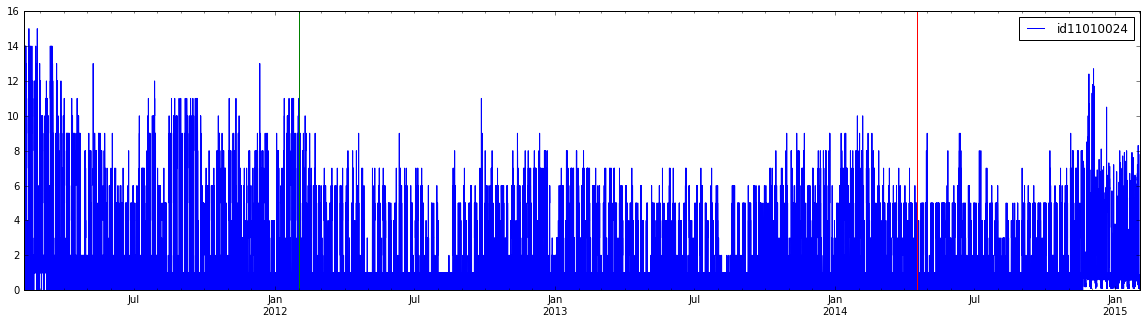

In [4]:
f = original_data[["id11010024"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

Testing how to iterate day by day

# Define Machine Learning Models and Data Sets

In [5]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
#from neural_network import PyBrainNN

C:\Python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Creating Feature Sets

In [6]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [7]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [8]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [9]:
#horizons = range(1,25)
#horizons = [1, 6, 12, 18, 24]
horizons = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]

baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             #{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             {'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             #{'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 #{'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 

In [10]:
def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    sensor_list = ['id11010024']
    #sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = sensor_data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            # baseline data
            training_data_bl = sensor_data[:original_splitting_time]
            testing_data_bl = sensor_data[original_splitting_time:]
            y_test_bl = testing_data_bl[["shifted_measurement"]].values.ravel()
            
            # batch approach
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_end_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            #bl = eval(baseline['init'])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test_bl)
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data_bl[bl.target])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                            
                    else:
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
                            if model['name'] == "Ridge Regression":
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
                            else:                               
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))

            # evaluation
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        bl = eval(baseline['init'])
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                        
                        for metric in error_metrics:
                            true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print validation_df


start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

output_file_name = "eval_top20_id11010024_big.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

Working with sensor: id11010024

	-->Prediction horizont: 1h. Shifting runtime: 1.03s

		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: AR_WF_DT. X_train: (77376L, 34L), y_train: (77376L,)
				-->Training model: Ridge Regression, runtime: 0.10s
				-->Training model: K Nearest Neighbors, runtime: 0.54s
				-->Training model: Random Forest, runtime: 8.01s

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: AR_WF_DT. X_train: (77472L, 34L), y_train: (77472L,)
				-->Training model: Ridge Regression, runtime: 0.18s
				-->Training model: K Nearest Neighbors, runtime: 0.53s
				-->Training model: Random Forest, runtime: 7.90s

		-->Evaluation (2014-04-20 00:00:00)
			-->Dat

C:\Python27\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
regression_metrics.py:27: RuntimeWarning: Found 10015 zero elements in y_pred. Removing 10015 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 0.557
					-->MAPE: 46.047
					-->R2: 0.123
					-->MAE: 0.867
					-->MAPE: 92.361
					-->R2: 0.432
					-->MAE: 0.696
					-->MAPE: 57.775
					-->R2: 0.727
					-->MAE: 0.585
					-->MAPE: 55.712
					-->R2: 0.413
					-->MAE: 0.856
					-->MAPE: 73.758
					-->R2: 0.793
					-->MAE: 0.466
					-->MAPE: 38.056
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,... 

regression_metrics.py:27: RuntimeWarning: Found 10155 zero elements in y_pred. Removing 10155 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10009 zero elements in y_pred. Removing 10009 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 0.919
					-->MAPE: 83.549
					-->R2: 0.123
					-->MAE: 0.867
					-->MAPE: 92.384
					-->R2: 0.432
					-->MAE: 0.697
					-->MAPE: 57.787
					-->R2: 0.649
					-->MAE: 0.688
					-->MAPE: 71.872
					-->R2: 0.352
					-->MAE: 0.896
					-->MAPE: 78.071
					-->R2: 0.748
					-->MAE: 0.536
					-->MAPE: 43.516
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,... 

regression_metrics.py:27: RuntimeWarning: Found 10141 zero elements in y_pred. Removing 10141 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10003 zero elements in y_pred. Removing 10003 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.212
					-->MAPE: 105.230
					-->R2: 0.123
					-->MAE: 0.868
					-->MAPE: 92.436
					-->R2: 0.432
					-->MAE: 0.697
					-->MAPE: 57.825
					-->R2: 0.624
					-->MAE: 0.722
					-->MAPE: 74.210
					-->R2: 0.304
					-->MAE: 0.929
					-->MAPE: 80.107
					-->R2: 0.719
					-->MAE: 0.555
					-->MAPE: 43.642
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10140 zero elements in y_pred. Removing 10140 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10001 zero elements in y_pred. Removing 10001 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.464
					-->MAPE: 120.854
					-->R2: 0.123
					-->MAE: 0.868
					-->MAPE: 92.540
					-->R2: 0.431
					-->MAE: 0.698
					-->MAPE: 57.864
					-->R2: 0.612
					-->MAE: 0.736
					-->MAPE: 75.143
					-->R2: 0.293
					-->MAE: 0.951
					-->MAPE: 81.447
					-->R2: 0.715
					-->MAE: 0.565
					-->MAPE: 44.284
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10077 zero elements in y_pred. Removing 10077 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10073 zero elements in y_pred. Removing 10073 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.789
					-->MAPE: 150.539
					-->R2: 0.124
					-->MAE: 0.869
					-->MAPE: 91.655
					-->R2: 0.431
					-->MAE: 0.699
					-->MAPE: 58.010
					-->R2: 0.614
					-->MAE: 0.737
					-->MAPE: 74.006
					-->R2: 0.317
					-->MAE: 0.943
					-->MAPE: 80.792
					-->R2: 0.726
					-->MAE: 0.566
					-->MAPE: 45.957
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10065 zero elements in y_pred. Removing 10065 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 10000 zero elements in y_pred. Removing 10000 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.725
					-->MAPE: 149.092
					-->R2: 0.130
					-->MAE: 0.867
					-->MAPE: 88.968
					-->R2: 0.430
					-->MAE: 0.700
					-->MAPE: 58.103
					-->R2: 0.610
					-->MAE: 0.733
					-->MAPE: 72.197
					-->R2: 0.299
					-->MAE: 0.948
					-->MAPE: 78.329
					-->R2: 0.711
					-->MAE: 0.572
					-->MAPE: 44.983
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10101 zero elements in y_pred. Removing 10101 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9995 zero elements in y_pred. Removing 9995 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.563
					-->MAPE: 136.282
					-->R2: 0.132
					-->MAE: 0.864
					-->MAPE: 88.377
					-->R2: 0.430
					-->MAE: 0.700
					-->MAPE: 58.095
					-->R2: 0.603
					-->MAE: 0.736
					-->MAPE: 72.319
					-->R2: 0.295
					-->MAE: 0.948
					-->MAPE: 79.701
					-->R2: 0.712
					-->MAE: 0.571
					-->MAPE: 45.683
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10105 zero elements in y_pred. Removing 10105 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9989 zero elements in y_pred. Removing 9989 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.358
					-->MAPE: 114.692
					-->R2: 0.132
					-->MAE: 0.865
					-->MAPE: 88.546
					-->R2: 0.429
					-->MAE: 0.700
					-->MAPE: 58.232
					-->R2: 0.601
					-->MAE: 0.733
					-->MAPE: 72.565
					-->R2: 0.294
					-->MAE: 0.942
					-->MAPE: 79.987
					-->R2: 0.716
					-->MAE: 0.560
					-->MAPE: 45.905
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10116 zero elements in y_pred. Removing 10116 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9984 zero elements in y_pred. Removing 9984 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 1.175
					-->MAPE: 110.950
					-->R2: 0.127
					-->MAE: 0.865
					-->MAPE: 88.854
					-->R2: 0.426
					-->MAE: 0.701
					-->MAPE: 58.413
					-->R2: 0.602
					-->MAE: 0.731
					-->MAPE: 72.332
					-->R2: 0.295
					-->MAE: 0.937
					-->MAPE: 79.258
					-->R2: 0.718
					-->MAE: 0.555
					-->MAPE: 45.943
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...

regression_metrics.py:27: RuntimeWarning: Found 10115 zero elements in y_pred. Removing 10115 zero elements
  warnings.warn(warning_msg, RuntimeWarning)
regression_metrics.py:27: RuntimeWarning: Found 9978 zero elements in y_pred. Removing 9978 zero elements
  warnings.warn(warning_msg, RuntimeWarning)



					-->MAE: 0.981
					-->MAPE: 99.792
					-->R2: 0.125
					-->MAE: 0.866
					-->MAPE: 88.982
					-->R2: 0.424
					-->MAE: 0.701
					-->MAPE: 58.586
					-->R2: 0.603
					-->MAE: 0.729
					-->MAPE: 72.509
					-->R2: 0.300
					-->MAE: 0.932
					-->MAPE: 79.795
					-->R2: 0.716
					-->MAE: 0.554
					-->MAPE: 46.452
sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,... 

regression_metrics.py:27: RuntimeWarning: Found 10121 zero elements in y_pred. Removing 10121 zero elements
  warnings.warn(warning_msg, RuntimeWarning)


In [13]:
output_file_name = "eval_top20_id11010024_big.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

In [11]:
validation_df

sensor                                                                            id11010024  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
                      K Nearest Neighbors  [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
                      Random Forest        [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
3.0     Last value    Baselines            [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
                      K Nearest Neighbors  [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
                      Random Forest        [[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
5.0     Last value    Baselines            [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
        Previous day  Baselines            [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
        Previous week Baselines            [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
        AR_WF_DT      Ridge Regression     [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
                      K Nearest Neighbors  [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
                      Random Forest        [[0.0, 1.0, 0.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0,...   
7.0     Last value    Baselines            [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
        Previous day  Baselines            [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
        Previous week Baselines            [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
        AR_WF_DT      Ridge Regression     [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
                      K Nearest Neighbors  [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
                      Random Forest        [[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0,...   
9.0     Last value    Baselines            [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
        Previous day  Baselines            [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
        Previous week Baselines            [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
        AR_WF_DT      Ridge Regression     [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
                      K Nearest Neighbors  [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
                      Random Forest        [[4.0, 2.0, 4.0, 3.0, 4.0, 3.0, 4.0, 1.0, 2.0,...   
...                                                                                      ...   
15.0    Last value    Baselines            [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
        Previous day  Baselines            [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
        Previous week Baselines            [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
        AR_WF_DT      Ridge Regression     [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
                      K Nearest Neighbors  [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
                      Random Forest        [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...   
17.0    Last value    Baselines            [[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...   
        Previous day  Baselines            [[1.0, 0.0, 0.0, 0.0,

### Evaluation results

In [ ]:
validation_df

### Evaluation results averaged over all testing days

In [ ]:
# validation_df['id12041992']['R2'][1.0].unstack()['Baselines'].unstack()['Last value'] # testing
validation_df.groupby(level=['horizon','dataset', 'model'], sort=False).mean()

## Results analysis

In [ ]:
validation_df

In [10]:
# read from csv
output_file_name = "testni_eval_id12041992.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1,2], header=[0,1])

test

sensor                                                                            id12041992  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous day  Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous week Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        AR_WF_DT      Ridge Regression     [ list([53.0, 43.100000000000001, 40.100000000...   
                      K Nearest Neighbors  [ list([53.0, 43.100000000000001, 40.100000000...   
                      Random Forest        [ list([53.0, 43.100000000000001, 40.100000000...   
6.0     Last value    Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        Previous day  Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        Previous week Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        AR_WF_DT      Ridge Regression     [ list([76.099999999999994, 98.0, 119.0, 112.0...   
                      K Nearest Neighbors  [ list([76.099999999999994, 98.0, 119.0, 112.0...   
                      Random Forest        [ list([76.099999999999994, 98.0, 119.0, 112.0...   
12.0    Last value    Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        Previous day  Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        Previous week Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        AR_WF_DT      Ridge Regression     [ list([122.0, 134.0, 152.30000000000001, 138....   
                      K Nearest Neighbors  [ list([122.0, 134.0, 152.30000000000001, 138....   
                      Random Forest        [ list([122.0, 134.0, 152.30000000000001, 138....   
18.0    Last value    Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        Previous day  Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        Previous week Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        AR_WF_DT      Ridge Regression     [ list([134.0, 138.0, 132.09999999999999, 117....   
                      K Nearest Neighbors  [ list([134.0, 138.0, 132.09999999999999, 117....   
                      Random Forest        [ list([134.0, 138.0, 132.09999999999999, 117....   
24.0    Last value    Baselines                                                   [list([])]   
        Previous day  Baselines                                                   [list([])]   
        Previous week Baselines                                                   [list([])]   
        AR_WF_DT      Ridge Regression     [ list([74.0, 69.299999999999997, 52.100000000...   
                      K Nearest Neighbors  [ list([74.0, 69.299999999999997, 52.100000000...   
                      Random Forest        [ list([74.0, 69.299999999999997, 52.100000000...   

sensor                                                                                        \
results                                                                            predicted   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [ 2014-04-17 00:00:00     71.0\r\n2014-04-17 0...   
        Previous day  Baselines            [ 2014-04-17 00:00:00     70.2\r\n2014-04-17 0...   
        Previous week Baselines            [ 2014-04-17 00:00:00     62.0\r\n2014-04-17 0...   
        AR_WF_DT      Ridge Regression     [ list([58.00834319889978, 60.087409773053196,...   
                      K Nearest Neighbors  [ list([62.5, 61.640000000000001, 64.0, 60.799...   
                      Random Forest        [ list([58.972323252

In [18]:
#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon','dataset', 'model']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 
    
horizons = [24]

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = sensor_data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            # baseline data
            training_data_bl = sensor_data[:original_splitting_time]
            testing_data_bl = sensor_data[original_splitting_time:]
            y_test_bl = testing_data_bl[["shifted_measurement"]].values.ravel()
            
            # batch approach
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_end_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            #bl = eval(baseline['init'])
                            
                            #test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test_bl)
                            #test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data_bl[bl.target])
                            
                            #test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                            #test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                            
                    else:
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
                            if model['name'] == "Ridge Regression":
                                test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
                                test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
                            else:                               
                                test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
                                test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))

            # evaluation
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        bl = eval(baseline['init'])
                        test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                        test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                        
                        for metric in error_metrics:
                            true = test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                            pred = test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

                            test.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = test.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                            error = metric['function'](true, pred)

                            test.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print test


start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#test

print "Finished."

output_file_name = "eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

test.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 24h. Shifting runtime: 0.71s

		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: AR_WF_DT. X_train: (77376L, 34L), y_train: (77376L,)
				-->Training model: Ridge Regression, runtime: 0.10s
				-->Training model: K Nearest Neighbors, runtime: 0.30s
				-->Training model: Random Forest, runtime: 11.29s

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: AR_WF_DT. X_train: (77472L, 34L), y_train: (77472L,)
				-->Training model: Ridge Regression, runtime: 0.19s
				-->Training model: K Nearest Neighbors, runtime: 0.31s
				-->Training model: Random Forest, runtime: 11.07s

		-->Evaluation (2014-04-20 00:00:00)
			-->

regression_metrics.py:27: RuntimeWarning: Found 4 zero elements in y_pred. Removing 4 zero elements
  warnings.warn(warning_msg, RuntimeWarning)


In [22]:
test

sensor                                                                            id12041992  \
results                                                                                 true   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous day  Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous week Baselines            [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        AR_WF_DT      Ridge Regression     [ list([53.0, 43.100000000000001, 40.100000000...   
                      K Nearest Neighbors  [ list([53.0, 43.100000000000001, 40.100000000...   
                      Random Forest        [ list([53.0, 43.100000000000001, 40.100000000...   
6.0     Last value    Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        Previous day  Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        Previous week Baselines            [array([  76.1,   98. ,  119. , ...,   71.3,  ...   
        AR_WF_DT      Ridge Regression     [ list([76.099999999999994, 98.0, 119.0, 112.0...   
                      K Nearest Neighbors  [ list([76.099999999999994, 98.0, 119.0, 112.0...   
                      Random Forest        [ list([76.099999999999994, 98.0, 119.0, 112.0...   
12.0    Last value    Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        Previous day  Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        Previous week Baselines            [array([ 122. ,  134. ,  152.3, ...,  135. ,  ...   
        AR_WF_DT      Ridge Regression     [ list([122.0, 134.0, 152.30000000000001, 138....   
                      K Nearest Neighbors  [ list([122.0, 134.0, 152.30000000000001, 138....   
                      Random Forest        [ list([122.0, 134.0, 152.30000000000001, 138....   
18.0    Last value    Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        Previous day  Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        Previous week Baselines            [array([ 134. ,  138. ,  132.1, ...,   65.7,  ...   
        AR_WF_DT      Ridge Regression     [ list([134.0, 138.0, 132.09999999999999, 117....   
                      K Nearest Neighbors  [ list([134.0, 138.0, 132.09999999999999, 117....   
                      Random Forest        [ list([134.0, 138.0, 132.09999999999999, 117....   
24.0    Last value    Baselines            [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   
        Previous day  Baselines            [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   
        Previous week Baselines            [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   
        AR_WF_DT      Ridge Regression     [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   
                      K Nearest Neighbors  [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   
                      Random Forest        [[74.0, 69.3, 52.1, 49.1, 55.1, 49.1, 52.0, 51...   

sensor                                                                                        \
results                                                                            predicted   
horizon dataset       model                                                                    
1.0     Last value    Baselines            [ 2014-04-17 00:00:00     71.0\r\n2014-04-17 0...   
        Previous day  Baselines            [ 2014-04-17 00:00:00     70.2\r\n2014-04-17 0...   
        Previous week Baselines            [ 2014-04-17 00:00:00     62.0\r\n2014-04-17 0...   
        AR_WF_DT      Ridge Regression     [ list([58.00834319889978, 60.087409773053196,...   
                      K Nearest Neighbors  [ list([62.5, 61.640000000000001, 64.0, 60.799...   
                      Random Forest        [ list([58.972323252

In [ ]:
test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']].mean()

In [ ]:
test.xs(["Baselines"], level=["model"]).unstack()['id12041992']['R2'].join(
        test.xs(["TOP_20"], level=["dataset"]).unstack()['id12041992']['R2']).loc[1]

Ploting R2 evaluation results for each day of testing data. We can see that on particular bad day lowers the overall average drastically.

In [ ]:
test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']].plot( kind='bar', figsize=(15,4))

Ploting evaluation results by ignoring negative R2 values. This is for horizon 1h into the future.

In [ ]:
a = test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

3 hours into the future.

In [ ]:
a = test.loc[3]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

5 hours into the future.

In [ ]:
a = test.loc[5]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

## Old code

In [ ]:
rec = {'training': [1, 2, 3], 'testing': [5, 6, 7]}
rec

In [ ]:
rec2 = [1,2,3]
rec2

In [ ]:
rec3 = np.array([5,6,7,8])
rec3

In [ ]:
rec4 = np.array([5,6,7,8], dtype='O')
rec4

In [ ]:
rec5 = pd.Series([5,6,7,8]).values
rec5

In [ ]:
rec6 = pd.Series([[5,6,7,8]]).values
rec6

In [ ]:
a = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric']), dtype='O') 

a.loc[(1, 'a', 'b'), ('c', 'd')] = rec6
#a.loc[(1, 'a', 'b'), ('c', 'd')] = rec4
#a[1.0]['a']['b']['c']['d']= 3
a

In [ ]:
#a['c','d'][1.0]['a']['b'] = pd.Series([5,6,7,8]).values
a['c','d'][1.0]['a']['b'] = 4
a

In [ ]:
#ref: https://stackoverflow.com/questions/39103060/adding-a-new-row-to-a-multiindex-pandas-dataframe-with-both-values-and-lists

df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                  columns=['predicted_y', 'actual_y', 'predicted_full', 'actual_full'])

#df.loc[('123', 3),['predicted_y', 'actual_y']] = [2, 5]
#df.loc[('123', 3),['predicted_full', 'actual_full']] = [[1,2,3], [4,5,6]]
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, [10, 20, 30], [40, 50, 60]] # doesent work
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = pd.Series([20, 50, [10, 20, 30], [40, 50, 60]]).values


# np.array as object
#df.loc[('321', 4),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, np.array([10,20,30], dtype='O'), np.array([40,50,60])]

# pd.Series 
df.loc[('123', 3),['predicted_full', 'actual_full']] =  pd.Series([[2, 5],[3,4]]).values

df

In [ ]:
#ref: https://stackoverflow.com/questions/39103060/adding-a-new-row-to-a-multiindex-pandas-dataframe-with-both-values-and-lists

df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                  columns=['true', 'predicted'])

#df.loc[('123', 3),['predicted_y', 'actual_y']] = [2, 5]
#df.loc[('123', 3),['predicted_full', 'actual_full']] = [[1,2,3], [4,5,6]]
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, [10, 20, 30], [40, 50, 60]] # doesent work
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = pd.Series([20, 50, [10, 20, 30], [40, 50, 60]]).values


# np.array as object
#df.loc[('123', 3),['true', 'predicted']] = [np.array([10,20,30], dtype='O'), np.array([40,50,60], dtype='O')]
#df.loc[('123', 3),'true'] = np.array([10,20,30], dtype='O')

# pd.Series 
#df.loc[('123', 3),['true', 'predicted']] =  pd.Series([[2, 5],[3,4]]).values
df.loc[('123', 3),'true'] =  pd.Series([[2, 5]]).values

df

In [ ]:
a = df.loc[('123', 3),'true']
a

In [ ]:
a

In [ ]:
a = pd.Series([[2, 5]]).values
a

In [ ]:
a[0].extend([2,4])
a

In [ ]:
l = [[2, 5]]
type(l)

In [ ]:
l = {}

In [ ]:
l['a'] = 'a'

In [ ]:
l

In [ ]:
pd.Series([[2, 5]]).values

In [ ]:
pd.Series([2, 5]).values

In [ ]:
a = np.array([5,6,7,8])
#df = pd.DataFrame({"a":[a]})
df = pd.DataFrame()
df.loc('a') = 3
df

In [ ]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            splitting_point = int(0.8 * data.shape[0])
            splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])

                            for metric in error_metrics:
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                               y_test, testing_data[bl.target])
                                else:
                                    error = metric['function'](y_test, testing_data[bl.target])

                                validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
"""
                    else:    
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                            for metric in error_metrics:
                                #print "\t-->Error metric: {}".format(metric['name'])

                                if model['name'] == "Ridge Regression":
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                                   y_test_dummy, mdl.predict(X_test_dummy))
                                    else:
                                        error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                                else: 
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                                   y_test, mdl.predict(X_test))
                                    else:
                                        error = metric['function'](y_test, mdl.predict(X_test))

                                #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
"""

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

In [ ]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

In [ ]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

### Save to file

In [ ]:
output_file_name = "validationResults_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

### Read from file

In [ ]:
output_file_name = "validationResults_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [ ]:
validation_df

## Evaluation Scores Over All Horizons

In [ ]:
validation_df.groupby(level=['dataset', 'model'], sort=False).mean()

In [ ]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel('R2')
    plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [ ]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

## Evaluation Scores for Each Horizon

In [ ]:
ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709']['R2']).plot(
    kind='bar', figsize=(20,5), title='R2 results - all horizons (id14061709)', ylim=(0,1), colormap='Blues')

for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')

ax.yaxis.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.), ncol=5, fancybox=True, shadow=True)
#plt.legend(loc=4)
plt.ylabel('R2 Score')

In [ ]:
for measure in validation_df.columns.levels[1]:
    
    ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709'][measure][['Last value', 'Previous week']].join(
        validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709'][measure]).plot(
        kind='bar', figsize=(20,5), colormap='Blues')
    
    ax.yaxis.grid()   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
    plt.ylabel(measure)
 

## Average Score by Sensors and Horizons

In [ ]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

In [ ]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.